# Exploring Data from multiple sources

In [52]:
!pip install matplotlib

  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-macosx_10_13_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp312-cp312-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)


In [55]:
!pip install rasterio geopandas pandas numpy xarray

  Using cached pyproj-3.7.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (31 kB)
  Using cached shapely-2.1.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 11.2 MB/s eta 0:00:00a 0:00:01
Using cached pyproj-3.7.1-cp312-cp312-macosx_14_0_arm64.whl (4.7 MB)
Using cached shapely-2.1.0-cp312-cp312-macosx_11_0_arm64.whl (1.6 MB)


In [61]:
import csv
import pandas as pd
import os
import xarray as xr
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from datetime import datetime

### San Bernardino County, CA data points on drought

In [31]:
path = os.getcwd()
print(path)

drought_df = pd.read_csv(path + '/src/SB_DroughtConditions.csv')
drought_df['Date'] = pd.to_datetime(drought_df['MapDate'], format='%Y%m%d')

drought_df.sort_values('Date', inplace=True)

# Calculate drought intensity index (weighted sum)
drought_df['Drought_Index'] = (drought_df['D0']*0.1 + drought_df['D1']*0.3 +
                              drought_df['D2']*0.5 + drought_df['D3']*0.7 +
                              drought_df['D4']*0.9)

print(drought_df)

/Users/aimeeoh/Desktop/Documents/ColumbiaMS/MLC/ML-Climate
       MapDate  FIPS                 County State   None      D0     D1  \
1317  20000104  6071  San Bernardino County    CA  85.97   14.03    0.0   
1316  20000111  6071  San Bernardino County    CA   0.00  100.00    0.0   
1315  20000118  6071  San Bernardino County    CA   0.00  100.00    0.0   
1314  20000125  6071  San Bernardino County    CA   0.00  100.00    0.0   
1313  20000201  6071  San Bernardino County    CA   0.00  100.00    0.0   
...        ...   ...                    ...   ...    ...     ...    ...   
4     20250304  6071  San Bernardino County    CA   0.00  100.00  100.0   
3     20250311  6071  San Bernardino County    CA   0.00  100.00  100.0   
2     20250318  6071  San Bernardino County    CA   0.00  100.00  100.0   
1     20250325  6071  San Bernardino County    CA   0.00  100.00  100.0   
0     20250401  6071  San Bernardino County    CA   0.00  100.00  100.0   

         D2     D3   D4  ValidStart    V

Based on 

In [76]:
# Modified preprocessing for water shortage data
def preprocess_water_data(water_df):
    # Convert categorical features to numerical
    risk_mapping = {'High': 3, 'Medium': 2, 'Low': 1, 'No': 0}
    water_df = water_df.replace({
        'RC2b_WildfireHazard': risk_mapping,
        'RC2f_Critically_Overdrafted': {'Yes': 1, 'No': 0},
        'RC3a_Well_Susceptibility': risk_mapping
    })
    
    # Select and convert numerical features
    water_features = [
        'RC1a_Temperature_Change', 'RC1c_Wildfire_Projections',
        'RC2b_WildfireHazard', 'RC2f_Critically_Overdrafted',
        'RC3a_Well_Susceptibility', 'Social_Vulnerability_Index'
    ]
    
    # Convert to numeric and handle errors
    for col in water_features:
        water_df[col] = pd.to_numeric(water_df[col], errors='coerce')
    
    # Aggregate by county (assuming County_CD is the identifier)
    water_agg = water_df.groupby('COUNTY_CD')[water_features].mean()
    
    return water_agg

### California Water Shortage Data

In [78]:
# Load and preprocess water shortage data
water_df = pd.read_csv(path + '/src/water_shortage.csv')
# County_CD for San Bernardino is 36 (https://notary.cdn.sos.ca.gov/forms/notary-county-codes.pdf)
water_df = water_df[water_df['COUNTY_CD'] == 36]
# print(water_df)

# Select and aggregate water shortage features
water_features = [
    'Date_Data_Refers_To','RC1a_Temperature_Change', 'RC1c_Wildfire_Projections',
    'RC2b_WildfireHazard', 'RC2f_Critically_Overdrafted',
    'RC3a_Well_Susceptibility', 'Social_Vulnerability_Index'
]
water_agg = preprocess_water_data(water_df)

print(water_agg)
# print(water_df)

           RC1a_Temperature_Change  RC1c_Wildfire_Projections  \
COUNTY_CD                                                       
36                        3.303501                   0.146201   

           RC2b_WildfireHazard  RC2f_Critically_Overdrafted  \
COUNTY_CD                                                     
36                     1.57991                     0.003671   

           RC3a_Well_Susceptibility  Social_Vulnerability_Index  
COUNTY_CD                                                        
36                         0.549844                   62.623765  


/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_18824/2447806747.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  water_df = pd.read_csv(path + '/src/water_shortage.csv')
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_18824/2362694035.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  water_df = water_df.replace({


### match datasets on county and date

In [82]:
# Define column names for merged dataset
merged_columns = [
    'Date','D0', 'D1', 'D2', 'D3', 'D4', 'Drought_Index',
    'RC1a_Temperature_Change', 'RC1c_Wildfire_Projections',
    'RC2b_WildfireHazard', 'RC2f_Critically_Overdrafted',
    'RC3a_Well_Susceptibility', 'Social_Vulnerability_Index'
]

# Create merged dataset
merged_data = []
for _, row in drought_df.iterrows():
    # Extract drought features
    drought_values = row[['Date','D0', 'D1', 'D2', 'D3', 'D4', 'Drought_Index']].values
    # Append water shortage features
    merged_row = np.append(drought_values, water_agg.values[0])
    merged_data.append(merged_row)

# Create DataFrame with column names
merged_df = pd.DataFrame(merged_data, columns=merged_columns)

# Save to CSV WITH headers
merged_df.to_csv('water_drought.csv', index=False)

# 1. Separate Dates and Features BEFORE Scaling
dates = merged_df['Date'].values  # Preserve dates for visualization
features = merged_df.drop(columns=['Date'])

# 2. Scale Only Numerical Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# 3. Create Sequences WITHOUT Dates
def create_sequences(data, targets, seq_length):
    """Create LSTM sequences from scaled features only"""
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])  # Features only
        y.append(targets[i+seq_length])  # Target (Drought_Index)
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(scaled_features, scaled_features[:, -1], seq_length)

# 4. Verify Shapes
print(f"Input shape: {X.shape}")  # (samples, timesteps, features)
print(f"Target shape: {y.shape}")  # (samples,)

Input shape: (1306, 12, 12)
Target shape: (1306,)


In [83]:
# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [84]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(seq_length, X.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [85]:
# Train with early stopping
history = model.fit(X_train, y_train,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.2,
                   callbacks=[EarlyStopping(patience=5)])

# Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss:.4f}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0089 - val_loss: 3.2024e-04
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6462e-04 - val_loss: 5.4055e-05
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2282e-04 - val_loss: 1.5142e-05
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6100e-04 - val_loss: 1.5826e-05
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1621e-04 - val_loss: 9.6229e-06
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2571e-04 - val_loss: 8.3857e-06
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2122e-04 - val_loss: 5.8554e-06
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9440e-05 - val_loss: 4.4309e-06
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9332e-05 - val_loss: 3.8258e-06
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9264e-05 - val_loss: 2.7131e-05
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9425e-05 -

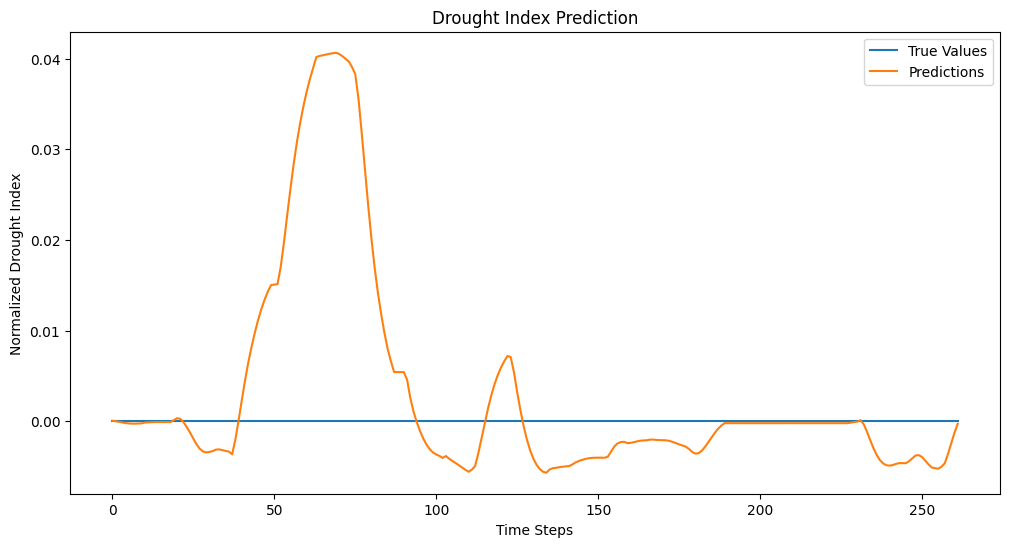

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


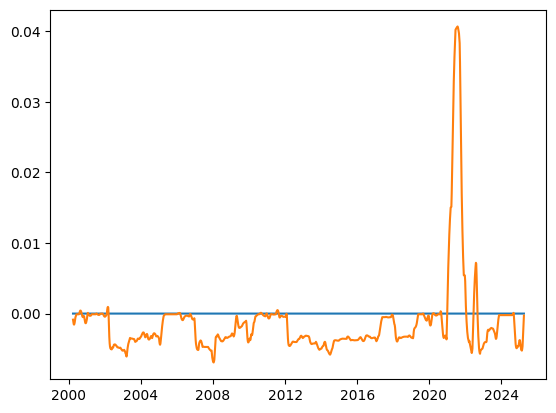

In [86]:
# Example prediction visualization
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('Drought Index Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Drought Index')
plt.legend()
plt.show()

# 6. For Visualization (Use Preserved Dates)
plot_dates = dates[seq_length:]  # Align with predictions
plt.plot(plot_dates, y, label='True')
plt.plot(plot_dates, model.predict(X), label='Predicted')

In [57]:
def process_prism_data(prism_folder="prism_downloads"):
    """Process PRISM COG grid packages with spatial aggregation"""
    prism_df = pd.DataFrame()
    
    # Load county boundaries (requires shapefile/GeoJSON)
    counties = gpd.read_file("ca_counties.geojson")  # Replace with actual path
    
    for date_folder in sorted(os.listdir(prism_folder)):
        folder_path = os.path.join(prism_folder, date_folder)
        if not os.path.isdir(folder_path):
            continue
            
        try:  # Extract date from folder name
            date = pd.to_datetime(date_folder, format="%Y%m%d")
        except ValueError:
            continue
            
        # Process all variables in the date folder
        for cog_file in os.listdir(folder_path):
            if cog_file.endswith(".tif"):
                var_name = cog_file.split("_")[0]  # e.g., "ppt", "tmean"
                with rasterio.open(os.path.join(folder_path, cog_file)) as src:
                    # Convert grid to dataframe
                    array = src.read(1)
                    transform = src.transform
                    
                    # Create grid coordinates
                    rows, cols = np.meshgrid(np.arange(array.shape[0]), 
                                           np.arange(array.shape[1]))
                    xs, ys = rasterio.transform.xy(transform, rows, cols)
                    
                    # Create GeoDataFrame
                    gdf = gpd.GeoDataFrame({
                        var_name: array.flatten(),
                        'geometry': [Point(x, y) for x, y in zip(xs.flatten(), ys.flatten())]
                    })
                    
                    # Spatial join with counties
                    gdf = gpd.sjoin(gdf, counties, how="inner", op="within")
                    
                    # Aggregate by county
                    agg_df = gdf.groupby('COUNTY_CD').agg({var_name: 'mean'}).reset_index()
                    agg_df['date'] = date
                    
                    prism_df = pd.concat([prism_df, agg_df], ignore_index=True)

    # Pivot to wide format
    prism_df = prism_df.pivot_table(index=['date', 'COUNTY_CD'], 
                                   columns=prism_df.columns[0], 
                                   values=prism_df.columns[0])
    return prism_df.reset_index()

# Modified data merging
def merge_all_data(prism_df, water_df):
    # Temporal alignment
    water_df['Date_Data_Refers_To'] = pd.to_datetime(water_df['Date_Data_Refers_To'])
    
    merged = pd.merge(
        prism_df,
        water_df,
        left_on=['date', 'COUNTY_CD'],
        right_on=['Date_Data_Refers_To', 'County_CD'],
        how='inner'
    )
    
    # Handle remaining missing data
    merged.interpolate(method='time', inplace=True)
    merged.ffill(inplace=True)
    
    return merged

# Updated feature engineering
def create_features(df):
    # Create drought intensity index from PRISM variables
    df['drought_index'] = (
        0.4 * df['ppt'] + 
        0.3 * df['tmean'] + 
        0.2 * df['soilmoisture'] + 
        0.1 * df['vpdmax']
    )
    
    # Temporal features
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    
    # Water shortage interaction terms
    df['water_stress'] = df['demand'] / df['water_supply']
    
    return df

In [96]:
## START FROM HERE

def load_prism_data(base_path, start_date='20190101', end_date='20241231'):
    data = []
    dates = []
    
    # Convert string dates to datetime objects
    start = datetime.strptime(start_date, '%Y%m%d')
    end = datetime.strptime(end_date, '%Y%m%d')
    
    for root, dirs, _ in os.walk(base_path):
        for dir_name in dirs:
            try:
                date = datetime.strptime(dir_name, '%Y%m%d')
                if start <= date <= end:
                    dir_path = os.path.join(root, dir_name)
                    daily_values = []
                    
                    # Process all .tif files in the date directory
                    for file in os.listdir(dir_path):
                        if file.endswith(".tif"):
                            with rasterio.open(os.path.join(dir_path, file)) as src:
                                array = src.read(1)
                                daily_values.append(np.nanmean(array))
                    
                    if daily_values:
                        data.append(np.mean(daily_values))  # Average of all tifs for the day
                        dates.append(date.strftime('%Y-%m-%d'))
                        
            except ValueError:
                continue  # Skip non-date formatted folders
    
    return pd.DataFrame({'Date': dates, 'PRISM_Avg': data})

def prepare_lstm_data(merged_df, sequence_length=30):
    # Extract features and target
    features = merged_df.drop(columns=['Date'])  # Assuming 'Date' is not used as a feature
    target = merged_df['PRISM_Avg'] if 'PRISM_Avg' in merged_df else features.iloc[:, 0]
    
    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(features)
    
    # Create sequences
    sequences = []
    targets = []
    for i in range(len(scaled_data) - sequence_length):
        sequences.append(scaled_data[i:i + sequence_length])
        targets.append(scaled_data[i + sequence_length, 0])  # Adjust index if target is different
    
    return np.array(sequences), np.array(targets), scaler

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [97]:
# Main execution
prism_folder = path + "/prism_unzipped"
water_drought_path = path + "/water_drought.csv"

print(water_drought_path)
water_drought = pd.read_csv(water_drought_path)

# Load and merge data
prism_df = load_prism_data(prism_folder)
print(prism_df)
prism_df['Date'] = pd.to_datetime(prism_df['Date'])

final_df = pd.merge(water_drought, prism_df, on='Date', how='left')

# Handle missing values if any
final_df.fillna(method='ffill', inplace=True)

# Prepare LSTM data
X, y, scaler = prepare_lstm_data(final_df)

# Train-test split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(final_df)

/Users/aimeeoh/Desktop/Documents/ColumbiaMS/MLC/ML-Climate/water_drought.csv
Empty DataFrame
Columns: [Date, PRISM_Avg]
Index: []
            Date      D0     D1     D2     D3   D4  Drought_Index  \
0     2000-01-04   14.03    0.0   0.00   0.00  0.0          1.403   
1     2000-01-11  100.00    0.0   0.00   0.00  0.0         10.000   
2     2000-01-18  100.00    0.0   0.00   0.00  0.0         10.000   
3     2000-01-25  100.00    0.0   0.00   0.00  0.0         10.000   
4     2000-02-01  100.00    0.0   0.00   0.00  0.0         10.000   
...          ...     ...    ...    ...    ...  ...            ...   
1313  2025-03-04  100.00  100.0  56.27  29.89  4.2         92.838   
1314  2025-03-11  100.00  100.0  56.27  29.89  4.2         92.838   
1315  2025-03-18  100.00  100.0  56.27  29.77  4.2         92.754   
1316  2025-03-25  100.00  100.0  56.27  29.77  4.2         92.754   
1317  2025-04-01  100.00  100.0  56.27  29.78  4.2         92.761   

      RC1a_Temperature_Change  RC1c_Wildf

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_18824/2279030696.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df.fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [91]:
# Build and train model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(X_train, y_train, 
                   epochs=50, 
                   batch_size=64,
                   validation_split=0.2)

# Evaluate
test_loss = model.evaluate(X_test, y_test)
print(f"Final Test Loss: {test_loss:.4f}")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: nan - val_loss: nan
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: nan - val_loss: nan
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - val_loss: nan
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: nan - val_loss: nan
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: nan - val_loss: nan
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: nan - val_loss: nan
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: nan - val_loss: nan
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: nan - val_loss: nan
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: nan - val_loss: nan
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: nan - val_loss: nan
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - val_loss: nan
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - val_loss: nan
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 